# Gaussian Mixture Model

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import peakutils
import sys
from sklearn import mixture
sys.path.insert(0, '..')
from database import mongo_client
from anomaly_detection import GMM
%matplotlib inline
from IPython.display import display
from IPython.display import HTML

## Selecting the number of components

### Bayesian Information Criterion

BIC = -2 * ln(L) + k ln(n)
with:
- L: maximized value of likelihood function of the model
- x: observed data
- theta: parameters of model
- n: number of observations
- k: number of free parameters to be estimated
Lowest BIC score gives best number of components

### 2 features

Fetching data for pattern ^MKI.(A|B).*B1:TEMP_TUBE_UP
Fetching data for MKI.B5L2.B1:TEMP_TUBE_UP
Fetching data for MKI.A5L2.B1:TEMP_TUBE_UP


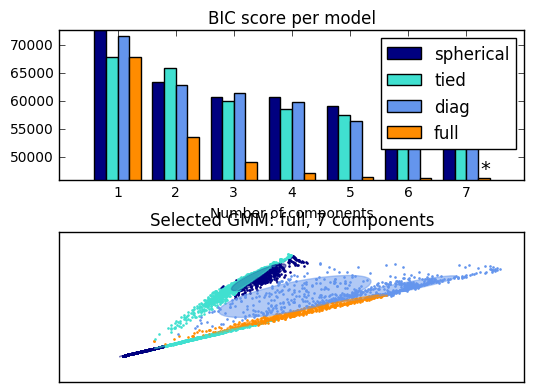

In [2]:
client = mongo_client.CERNMongoClient()
df = client.query_resample("^MKI.(A|B).*B1:TEMP_TUBE_UP", '30T')
data = df.values
GMM.component_selection(data)

A GMM is fitted with up to 7 components and 4 different types of covariance matrices. From the documentation of sklearn:
- 'full' (each component has its own general covariance matrix),
- 'tied' (all components share the same general covariance matrix),
- 'diag' (each component has its own diagonal covariance matrix),
- 'spherical' (each component has its own single variance).

The data used is the TEMP_TUBE_UP of B1 of magnets A and B. The data is resampled to 30 minutes.
The top part of the figure show the BIC score for all these combinations. The lowest BIC score is best.
The bottom plot show the data with the components. The x-axis is the data of magnet B, the y-axis of magnet A. All points not within an ellipse can be considered anomalies.

### Complex example

Fetching data for pattern ^MKI.(A|B).*B1:.*
Fetching data for MKI.A5L2.B1:TEMP_MAGNET_UP
Fetching data for MKI.B5L2.B1:PRESSURE
Fetching data for MKI.B5L2.B1:TEMP_TUBE_DOWN
Fetching data for MKI.A5L2.B1:TEMP_TUBE_DOWN
Fetching data for MKI.B5L2.B1:PRESSURE_INT
Fetching data for MKI.B5L2.B1:TEMP_MAGNET_DOWN
Fetching data for MKI.B5L2.B1:TEMP_TUBE_UP
Fetching data for MKI.A5L2.B1:TEMP_TUBE_UP
Fetching data for MKI.A5L2.B1:PRESSURE_INT
Fetching data for MKI.B5L2.B1:TEMP_MAGNET_UP
Fetching data for MKI.A5L2.B1:PRESSURE
Fetching data for MKI.A5L2.B1:TEMP_MAGNET_DOWN


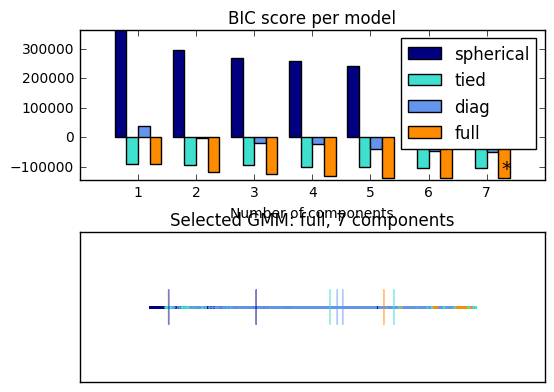

In [3]:
client = mongo_client.CERNMongoClient()
df = client.query_resample("^MKI.(A|B).*B1:.*", '30T')
data = df.values
GMM.component_selection(data)

The data used here is all fixed frequency data for B1 and magnets A & B. The BIC is negative here for most of the covariance matrices and keeps going down if more components are added. It does stagnate around 5. What is expected is a point where the score goes up again. This is because the BIC score gives a penalty to more components.
Reasons for this could be:
- overfitting
- to many features
- non-gaussian data
- data not normalized

The second plot is MKI.A5L2.B1:TEMP_MAGNET_UP on the x-axis and MKI.B5L2.B1:PRESSURE on the y-axis. GMM seems to have no way to rank features on influence on components

## Anomaly Detection

In [24]:
X, _ = df.shape
train_length = int(round(0.5 * X))
train_data = df.iloc[:train_length, :].values
test_data = df.iloc[train_length:, :].values
display(train_data.shape)
display(test_data.shape)

clf = mixture.GaussianMixture(n_components=5, covariance_type='full')
clf.fit(train_data)

(2040, 12)

(2040, 12)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=5, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

The data is split in 80% training data and 20% test data. 

In [27]:
test_log_probs = clf.score_samples(test_data)
display(test_log_probs.mean())
display(test_log_probs.min())
display(test_log_probs.max())
pct = np.percentile(test_log_probs, 10)
display(pct)
idx = np.where(test_log_probs<pct)
anomalies = test_data[idx]

14.061654606816097

-7.6276712514651583

25.018463054284091

5.7230800052474491

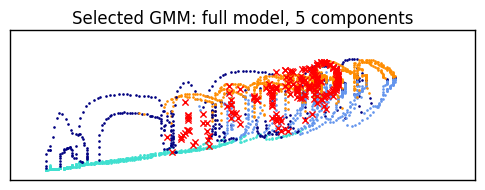

In [37]:
import itertools
from scipy import linalg
import matplotlib as mpl
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(train_data)
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
                                           color_iter)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(train_data[Y_ == i, 0], train_data[Y_ == i, 2], .8, color=color)

plt.scatter(anomalies[:, 0], anomalies[:, 2], marker='x', color='red')

plt.xticks(())
plt.yticks(())
plt.title('Selected GMM: full model, 5 components')
plt.subplots_adjust(hspace=.35, bottom=.02)
plt.show()

Anomalies are taken as the data in the testset in the 10 percentile of weighted log probabilities (test_log_probs). 
The plot show the 0th and 2nd column of the dataset in x- and y-axis. These are MKI.A5L2.B1:TEMP_MAGNET_UP and MKI.B5L2.B1:TEMP_TUBE_DOWN. These could very well be unimportant features, but there is no function to rank features.
Colored dots are the 5 components in the training set. The red x'es are the anomalies of the test set.

In [38]:
test_components = clf.predict(test_data)
unique, counts = np.unique(test_components, return_counts=True)
display(dict(zip(unique, counts)))

{0: 232, 1: 965, 2: 367, 3: 427, 4: 49}

Output means: 481 points in component 0, 254 in component 1 etc

In [39]:
test_probabilities = clf.predict_proba(test_data)
display(test_probabilities.mean(axis=0))

array([ 0.11883471,  0.47232381,  0.17668731,  0.20831344,  0.02384073])

Output gives the mean probabilities of points belonging to that component.